###  Lot of nonsense going on in this file, main interesting this is first bit looking at which radial function to use

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import sys
import pandas as pd
import scipy.stats as stats

sys.path.append('C:/Users/conor/Documents/Github/Project/plugins')

import importlib
import gof_testing as goft #located in 'plugins'
import helper_functions_other as hf
import modelling_testing as md
import modelling_newest as mdn
importlib.reload(goft)
importlib.reload(hf)
importlib.reload(md)
importlib.reload(mdn)

You specified _auto_append_rucio_local=True and you are not on dali compute nodes, so we will add the following rucio local path: /project/lgrandi/rucio/


Unknown config option xedocs_version; will do nothing.
Invalid context option xedocs_version; will do nothing.


('subtype_mask',) 0.2.1
('pS2_relabel',) 0.0.0
('wf_piecewise_info',) 0.0.1
('n_electron_rec',) 0.0.2


<module 'modelling_newest' from 'C:\\Users/conor/Documents/Github/Project/plugins\\modelling_newest.py'>

### Radial function investigation

We are interested in introducing a fiducial volume cut to our model. We want to remove all single/delayed electrons in the outer radius of the model, as this is the area we believe to have the largest background.

However, there are also many pS2s that occur in this region, meaning many of their 'related' electrons will get cut. Conversely, pS2s near the edge of the inner fiducial volume may have 'related' electrons cut also. All this to say, the model without a radial parameter will vastly over-predict the amount of electrons we should be expecting each pS2 to contribute to the rate model. So, we need to introduce some kind of radial function in order to remedy this in our predictive model.

There are two initial options, shown below:
1) A purely geometric cut. We define two circles, one being the inner fiducial radius (e.g. 45cm from the centre), and the other being a radius around a given pS2, in which we define the given electrons to be "position-correlated" to that pS2 (More info about this can be found in the file: TODO add file, and in Noah Hood's note: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:noahhood:s2only:position_correlation). Thus, we can find a function which tells us, at a given radius, how much of that smaller circle lies within the larger one, thus giving us a scaling parameter between 1 and 0 for how many of the predicted electrons get cut by the fiducial volume cut.

2) A sigmoid function. This is the one I am currently going with, as it is not as strict as the geometric cut, and allows for more "fuzziness" in terms of the transition between the inside and outside of the fiducial volume radius, in terms of what fraction of electrons we might consider to be getting cut from any given pS2 in any given location. Although the position-correlation idea is nice, this is of course not a full position-correlated model, and it would be a very difficult task to make it as such, so this function perhaps allows more leeway in the idea that, even in the centre of the detector, some of a pS2s 'related' electrons may in fact be detected far outside of the fiducial volume, and vice versa for pS2s far on the edge of the detector. What this looks like in practice is that the function does not go fully to 0 at the detector boundary, and does not go fully to 1 at the detector centre.

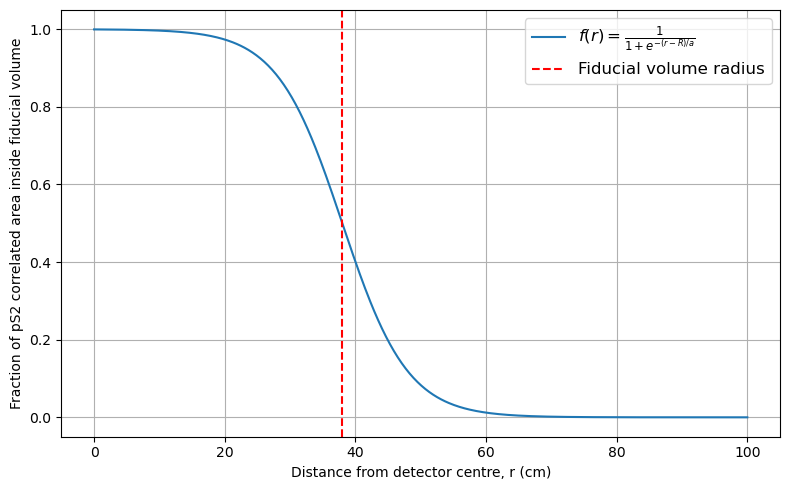

In [2]:
# Constants
R = 38 # radius of fiducial volume (cm) -- Need to actually check this number
a = 5  # radius of position-correlation circle (cm)

def overlap_area(r, R, a):
    d = r
    # Handle case where d == 0 to avoid division by zero
    if d == 0:
        return np.pi * a**2
    
    # Clamp values to avoid numerical issues in arccos
    part1 = (d**2 + a**2 - R**2) / (2 * d * a)
    part2 = (d**2 + R**2 - a**2) / (2 * d * R)
    part1 = np.clip(part1, -1, 1)
    part2 = np.clip(part2, -1, 1)
    
    term1 = a**2 * np.arccos(part1)
    term2 = R**2 * np.arccos(part2)
    term3 = 0.5 * np.sqrt(
        (-d + a + R) *
        (d + a - R) *
        (d - a + R) *
        (d + a + R)
    )
    
    return term1 + term2 - term3

# Fractional area function
def f(r):
    if r <= R - a:
        return 1.0
    elif r >= R + a:
        return 0.0
    else:
        return overlap_area(r, R, a) / (np.pi * a**2)

# Generate r values and compute f(r)
r_values = np.linspace(0, 100, 500)
f_values = np.array([f(r) for r in r_values])

# Plot
plt.figure(figsize=(8, 5))
# plt.plot(r_values, f_values, label='Fraction of area inside inner circle')
# plt.plot(r_values, expit(-(r_values - R)/a), label = 'Expit function' )
plt.plot(r_values, expit(-(r_values - R)/a), label = r'$f(r) = \frac{1}{1 + e^{-(r - R)/a}}$')
# plt.axvline(R - a, color='gray', linestyle='--', label = f'R - a, ({R - a}cm)')
# plt.axvline(R + a, color='gray', linestyle='--', label = f'R + a ({R + a}cm)')
plt.xlabel('Distance from detector centre, r (cm)')
plt.ylabel('Fraction of pS2 correlated area inside fiducial volume')
plt.axvline(R, color = 'red', linestyle='--', label = 'Fiducial volume radius')
plt.legend(fontsize = 12)
plt.grid(True)
plt.tight_layout()
plt.show()

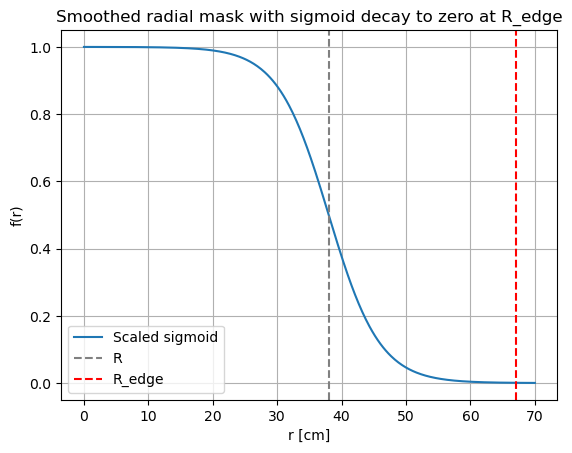

In [86]:
import numpy as np
import matplotlib.pyplot as plt

R = 38  # cm
scaling = 5   # cm
R_edge = 67  # cm
epsilon = 0.01  # value at R_edge

# Compute scaling factor
h = (a / (R_edge - R)) * np.log((1 - epsilon) / epsilon)

# Define the modified sigmoid
def scaled_sigmoid(r, R, scaling, h):
    return 1 / (1 + np.exp((r - R) / (scaling * h)))

# Plot
r_values = np.linspace(0, 70, 500)
plt.plot(r_values, scaled_sigmoid(r_values, R, scaling, h), label = "Scaled sigmoid")
plt.axvline(R, color = 'gray', linestyle = '--', label = 'R')
plt.axvline(R_edge, color = 'red', linestyle = '--', label = 'R_edge')
plt.xlabel('r [cm]')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.title("Smoothed radial mask with sigmoid decay to zero at R_edge")
plt.show()


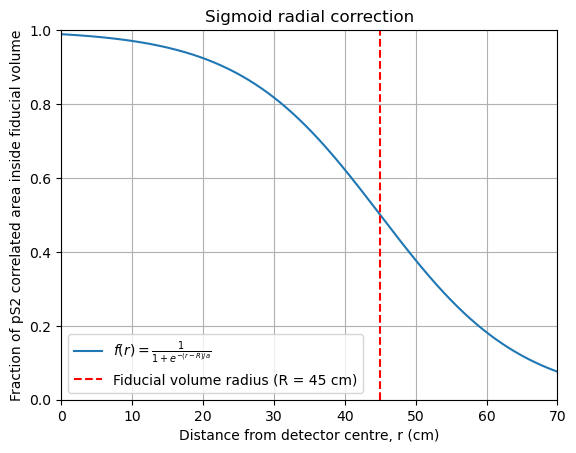

In [4]:
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0, 70, 500)
y = 1 / (1 + np.exp((r - 45) / 10))
plt.plot(r, y, label = r'$f(r) = \frac{1}{1 + e^{-(r - R)/a}}$')
plt.axvline(45, color='red', linestyle='--', label= 'Fiducial volume radius (R = 45 cm)')
plt.xlim(0, 70)
plt.ylim(0, 1)
plt.xlabel('Distance from detector centre, r (cm)')
plt.ylabel('Fraction of pS2 correlated area inside fiducial volume')
plt.title("Sigmoid radial correction")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#TODO: Go on to midway and get new data, see stuff idk

pS2s = np.load("C:/Users/conor/Downloads/Project (offline)/downloaded_data/031680_pS2s.npy", allow_pickle = True)
DEs = np.load("C:/Users/conor/Downloads/Project (offline)/downloaded_data/031680_DEs.npy", allow_pickle = True)
peaks = np.load("C:/Users/conor/Downloads/Project (offline)/downloaded_data/031680_peaks.npy",allow_pickle = True)
# DAQ_vetos = np.load("C:/Users/conor/Downloads/Project (offline)/downloaded_data/031680_vetos.npy", allow_pickle = True)
runs = np.load("C:/Users/conor/Downloads/Project (offline)/downloaded_data/runs.npy", allow_pickle = True)

runs_df = pd.DataFrame(runs, columns = ["name", "number", "mode", "end", "start", "tags", "source", 
                                     "livetime", "peak_basics_available", "peaks_available", "event_basics_available"])


run_id = runs_df.iloc[-2]

DEs_cut = hf.DE_cuts(run_id, DEs)

55235 electrons cut, representing 72.92% of all electrons


### Max_recent peak investigation

Basically this is just seeing, instead of the model looking at all previous peaks in time in order to form a rate calculation, instead what is the minimum amount of peaks we need to look back at in order to get a relatively good model (or conversely, what is the max we need to look back on for the model to start getting close again)

I've sort of looked at two things here: 1) how close the max_recent model is to the current model, and 2) how close the max_recent model is to the real data

In [6]:
# #Also going to show investigation of n-peak look-back, how I came to the value I did:
# from numba import njit

# @njit
# def compute_norms(s, c, d, r0, scaling, areas, ranges, r):
#     return s * (areas ** c) * (ranges ** d) * (1 / (1 + np.exp((r - r0) / scaling)))

# seconds_range = (10, 150)
# s2_roi, se_roi, vals, cov = md.time_fitting_buffer(run_id, pS2s, DEs_cut, seconds_range = seconds_range, filename = "new_results.csv")

# s = vals['s']
# c = vals['c']
# d = vals['d']
# r0 = vals['r0']
# scaling = vals['scaling']
# tmin = vals['tmin']
# n = vals['n']
# k = vals['k']

In [7]:
# t = np.arange(seconds_range[0] * 1e3, seconds_range[1] * 1e3, 1)  # in ms
# s2_times = np.asarray(s2_roi['time since start']) #Already in ms
# s2_areas = s2_roi['area']
# s2_ranges = s2_roi['range_50p_area'] / 1e6  # Convert to ms
# s2_radii = s2_roi['r']

# t_all = np.asarray(t[:, None] - s2_times[None, :])

# valid_mask = t_all >= tmin

# norms = compute_norms(s, c, d, r0, scaling, s2_areas, s2_ranges, s2_radii)
# norms_broadcasted = norms[None, :]

# dist = stats.pareto(scale = tmin, b = n - 1)

# #Old method
# pdf_vals = np.zeros_like(t_all)
# pdf_vals[valid_mask] = dist.pdf(t_all[valid_mask])
# old_differential_rate = (norms_broadcasted * pdf_vals).sum(axis = 1)

# #Remove events within S2 times and S2 times + tmin, those that 'bleed' into those regions
# # Doing print(events_cut.sum()) shows that we are excluding a small amount of events, so working as intended
# events_cut = (norms_broadcasted * 
#                 (dist.cdf(s2_times + tmin)
#                 - dist.cdf(s2_times))).sum(axis = 1)

# total = norms.sum() - events_cut.sum() + (k * (np.max(t) - np.min(t)))

# old_diffs = old_differential_rate + k

# # print(old_diffs)

# #Trying the new method, looking at n-peaks back, rather than all peaks in the past.
# def evaluate_error(max_recent_val):
#     masked_t_all = np.where(valid_mask, t_all, np.inf)
#     sort_idx = np.argsort(masked_t_all, axis=1)
#     recent_indices = sort_idx[:, :max_recent_val]
#     row_idx = np.arange(t_all.shape[0])[:, None]
    
#     recent_diffs = t_all[row_idx, recent_indices]
#     recent_norms = norms[recent_indices]
#     recent_pdfs = dist.pdf(recent_diffs)
#     differential_rate = (recent_norms * recent_pdfs).sum(axis=1)
#     diff = differential_rate + k
    
#     rel_error = np.abs(diff - old_diffs) / old_diffs
#     mean_rel_error = np.mean(rel_error)
    
#     return mean_rel_error

# # Try a range of values
# for m in [150]:
#     rel_err = evaluate_error(m)
#     print(f"max_recent = {m:3d} | mean rel. error = {rel_err:.5f} | % diff: {100 * rel_err:.2f}%")

# # #Arbitrarily want to get a % diff of 1%, as a balance between speed and accuracy
# # print("\n")
# # for m in np.arange(76, 90, 1):
# #     rel_err = evaluate_error(m)
# #     print(f"max_recent = {m:3d} | mean rel. error = {rel_err:.5f} | % diff: {100 * rel_err:.2f}%")


In [8]:
# #This is all well and good, but it's just for one small range of seconds, so let's do this all again, but for more ranges:

# def evaluate_error(max_recent_val, old_diffs, t_all, norms, valid_mask, k, dist):
#     masked_t_all = np.where(valid_mask, t_all, np.inf)
#     sort_idx = np.argsort(masked_t_all, axis=1)
#     recent_indices = sort_idx[:, :max_recent_val]
#     row_idx = np.arange(t_all.shape[0])[:, None]
    
#     recent_diffs = t_all[row_idx, recent_indices]
#     recent_norms = norms[recent_indices]
#     recent_pdfs = dist.pdf(recent_diffs)
#     differential_rate = (recent_norms * recent_pdfs).sum(axis=1)
#     diff = differential_rate + k
    
#     rel_error = np.abs(diff - old_diffs) / old_diffs
#     mean_rel_error = np.mean(rel_error)
    
#     return mean_rel_error

# def eval(seconds_range):
#     s2_roi, _, vals, _ = md.time_fitting_buffer(run_id, pS2s, DEs_cut, seconds_range = seconds_range, filename = "new_results.csv")

#     s = vals['s']
#     c = vals['c']
#     d = vals['d']
#     r0 = vals['r0']
#     scaling = vals['scaling']
#     tmin = vals['tmin']
#     n = vals['n']
#     k = vals['k']

#     t = np.arange(seconds_range[0] * 1e3, seconds_range[1] * 1e3, 1)  # in ms
#     s2_times = s2_roi['time since start'] #Already in ms
#     s2_areas = s2_roi['area']
#     s2_ranges = s2_roi['range_50p_area'] / 1e6  # Convert to ms
#     s2_radii = s2_roi['r']

#     t_all = np.asarray(t[:, None] - s2_times[None, :])

#     valid_mask = t_all >= tmin

#     norms = compute_norms(s, c, d, r0, scaling, s2_areas, s2_ranges, s2_radii)
#     norms_broadcasted = norms[None, :]

#     dist = stats.pareto(scale = tmin, b = n - 1)

#     #Old method
#     pdf_vals = np.zeros_like(t_all)
#     pdf_vals[valid_mask] = dist.pdf(t_all[valid_mask])
#     old_differential_rate = (norms_broadcasted * pdf_vals).sum(axis = 1)

#     old_diffs = old_differential_rate + k

#     # print(old_diffs)

#     #Trying the new method, looking at n-peaks back, rather than all peaks in the past.
#     best_m = None
#     rel_errs = []
#     for m in np.arange(60, 101, 1):
#         rel_err = evaluate_error(m, old_diffs, t_all, norms, valid_mask, k, dist)
#         rel_errs.append(rel_err)
#         print(f"max_recent = {m:3d} | mean rel. error = {rel_err:.5f} | % diff: {100 * rel_err:.2f}%")
#         #Want to find the maximum recent value that gives a mean relative error of less than 1%
#         if rel_err < 0.01:
#             best_m = m
#             break

#     return best_m, rel_errs


# #Want to evaluate a wide range of seconds ranges, both in region and length, bearing in mind the run goes to ~1800s:
 
# seconds_ranges = [(10, 30), (10, 60), (10, 120), (10, 180),
#                  (30, 60), (30, 120), (30, 180), 
#                  (60, 120), (60, 180), (120, 180), 
#                  (10, 300), (10, 600), (10, 900), 
#                  (30, 300), (30, 600), (30, 900), 
#                  (60, 300), (60, 600), (60, 900),
#                  (120, 300), (120, 600), (120, 900),
#                  (180, 300), (180, 600), (180, 900)]

# max_recent_values, relative_errors = [], []
# for seconds_range in seconds_ranges:
#     print(f"Evaluating seconds range: {seconds_range}")
#     m, rel_errs = eval(seconds_range)
#     max_recent_values.append(m)
#     relative_errors.append(rel_errs)

# max_recent_values = [m for m in max_recent_values if m is not None]
# if max_recent_values:
#     m_mean = np.mean(max_recent_values)
#     print(f"\nMean max_recent value across all ranges: {m_mean:.2f}")
# else:
#     print("\nNo valid max_recent values found across any range.")


# #TODO: error is really high just for e.g. 10 - 60s? WHY?

Evaluating seconds range: (15, 30)

----------------------------------------------------------------------------------------------------

This selection will incorporate 376 pS2s
Corresponding to the seconds range of: 0.30 to 29.96
Running the cost function now
Minimisation Status: 
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3215                       │              Nfcn = 583              │
│ EDM = 6.82e-05 (Goal: 0.0002)    │           time = 14.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├───────────────────────────────

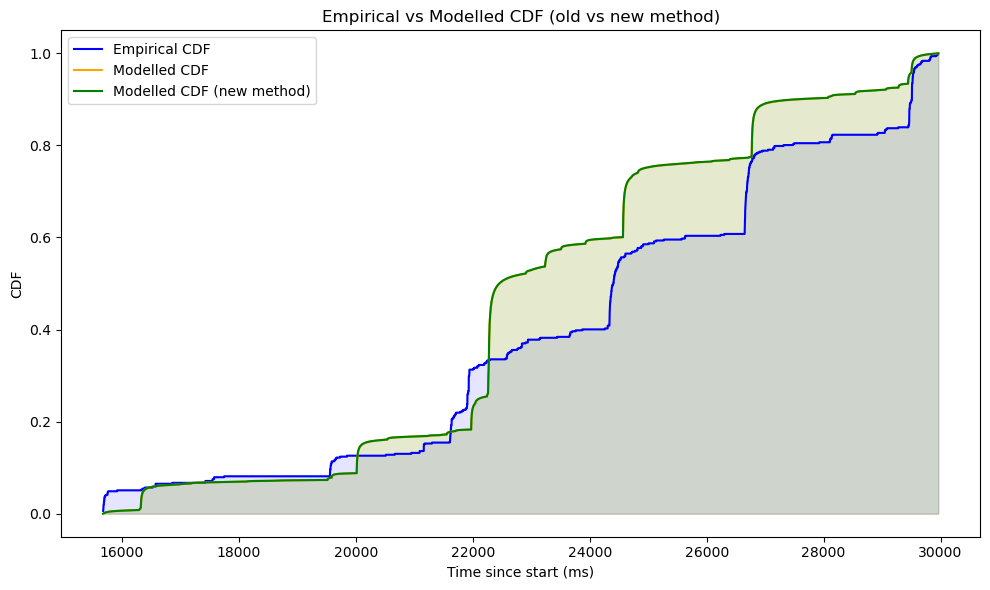

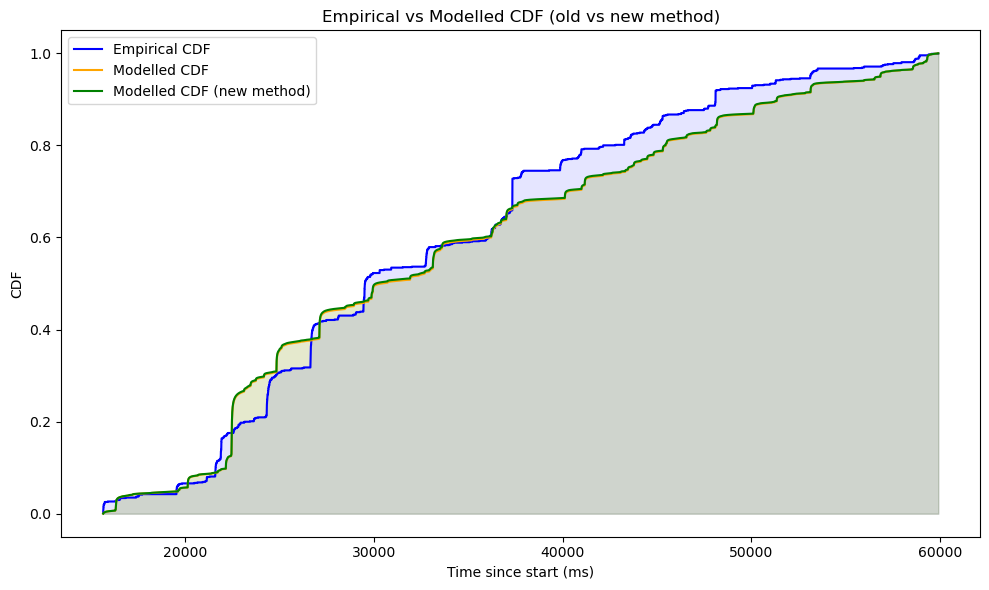

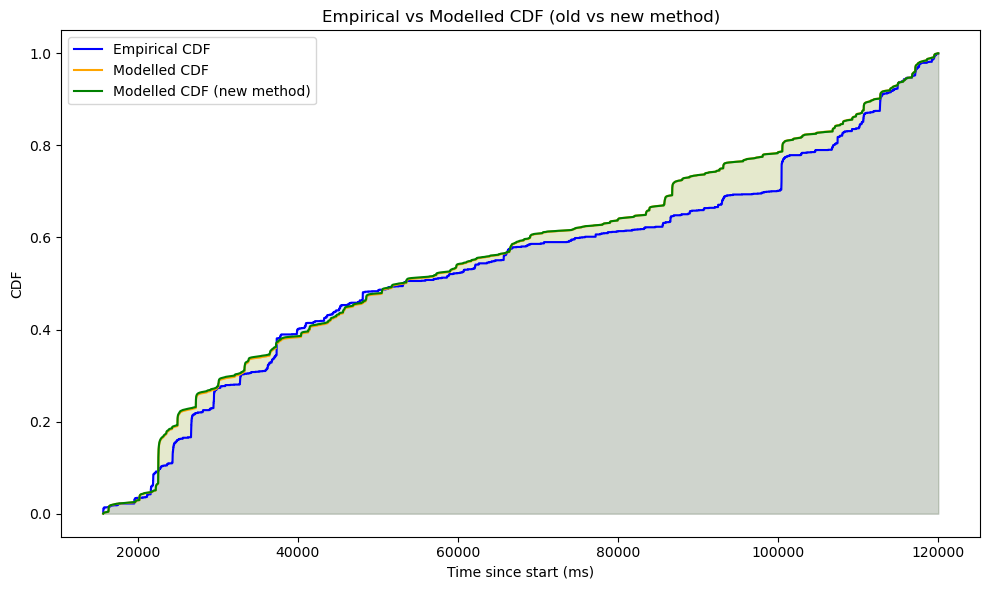

In [10]:
from numba import njit
from scipy import stats

@njit
def compute_norms(s, c, d, r0, scaling, areas, ranges, r):
    #Have left r0 and scaling as parameters, could later bring them back and fix them here if I wanted?
    R_edge = 67  # cm, detector edge radius
    epsilon = 0.01  # value at R_edge
    r0 = 45
    scaling = 10
    s = (scaling / (R_edge - r0)) * np.log((1 - epsilon) / epsilon)
    return s * (areas ** c) * (ranges ** d) * (1 / (1 + np.exp((r - r0) / scaling * s)))

def evaluate_error(max_recent_val, old_diffs, t_all, norms, valid_mask, k, dist):
    masked_t_all = np.where(valid_mask, t_all, np.inf)
    sort_idx = np.argsort(masked_t_all, axis=1)
    recent_indices = sort_idx[:, :max_recent_val]
    row_idx = np.arange(t_all.shape[0])[:, None]
    
    recent_diffs = t_all[row_idx, recent_indices]
    recent_norms = norms[recent_indices]
    recent_pdfs = dist.pdf(recent_diffs)
    differential_rate = (recent_norms * recent_pdfs).sum(axis=1)
    diff = differential_rate + k
    
    rel_error = np.abs(diff - old_diffs) / old_diffs
    mean_rel_error = np.mean(rel_error)
    
    return mean_rel_error, diff

def evaluate_empirical_error(rate_model, times, se_times):
    """
    rate_model: array of predicted differential rates (same shape as times)
    se_times: array of SE timestamps (in ms)
    """
    # Ensure histogram bins match length of rate_model
    hist_bins = np.arange(times[0], times[0] + len(times) + 1, 1)
    se_counts, _ = np.histogram(se_times, bins = hist_bins)

    # Scale prediction to match total SE count
    predicted_counts = rate_model * (np.sum(se_counts) / np.sum(rate_model))

    abs_error = np.mean(np.abs(se_counts - predicted_counts))
    return abs_error


def eval(seconds_range):
    s2_roi, se_roi, vals, _ = mdn.time_fitting_buffer(run_id, pS2s, DEs_cut, seconds_range = seconds_range, filename = "new_results.csv")

    s = vals['s']
    c = vals['c']
    d = vals['d']
    r0 = vals['r0']
    scaling = vals['scaling']
    tmin = vals['tmin']
    n = vals['n']
    k = vals['k']

    t = np.arange(seconds_range[0] * 1e3, seconds_range[1] * 1e3, 1)  # in ms
    s2_times = s2_roi['time since start'] #Already in ms
    s2_areas = s2_roi['area']
    s2_ranges = s2_roi['range_50p_area'] / 1e6  # Convert to ms
    s2_radii = s2_roi['r']

    t_all = np.asarray(t[:, None] - s2_times[None, :])

    valid_mask = t_all >= tmin

    norms = compute_norms(s, c, d, r0, scaling, s2_areas, s2_ranges, s2_radii)
    norms_broadcasted = norms[None, :]

    dist = stats.pareto(scale = tmin, b = n - 1)

    #Old method
    pdf_vals = np.zeros_like(t_all)
    pdf_vals[valid_mask] = dist.pdf(t_all[valid_mask])
    old_differential_rate = (norms_broadcasted * pdf_vals).sum(axis = 1)

    old_diffs = old_differential_rate + k

    # print(old_diffs)

    #Trying the new method, looking at n-peaks back, rather than all peaks in the past.


    def find_best_m(min_m, max_m, old_diffs, t_all, norms, valid_mask, k, dist):
        best_m = None
        best_emp_m_new = None
        min_emp_err_new = np.inf
        rel_errs = []
        emp_old_error, emp_new_error = [], []
        best_diff = None
        while min_m <= max_m:
            m = (min_m + max_m) // 2
            rel_err, diff = evaluate_error(m, old_diffs, t_all, norms, valid_mask, k, dist)
            emp_error_old = evaluate_empirical_error(old_diffs, t, se_roi['time since start'])
            emp_error_new = evaluate_empirical_error(diff, t, se_roi['time since start'])  # from new method
            rel_errs.append(rel_err)
            emp_old_error.append(emp_error_old)
            emp_new_error.append(emp_error_new)
            
            if emp_error_new < min_emp_err_new:
                min_emp_err_new = emp_error_new
                best_emp_m_new = m
                best_diff = diff

            if rel_err < 0.01:
                best_m = m
                max_m = m - 1  # Search lower for earlier valid m
            else:
                min_m = m + 1
        return best_m, rel_errs, best_emp_m_new, min_emp_err_new, emp_old_error, emp_new_error, best_diff

    best_m, rel_errs, best_emp_m_new, min_emp_err_new, emp_old_err, emp_new_err, new_diff = find_best_m(10, 300, old_diffs, t_all, norms, valid_mask, k, dist)

    return best_m, rel_errs, best_emp_m_new, min_emp_err_new, emp_old_err, emp_new_err, new_diff, old_diffs, se_roi


#Want to evaluate a wide range of seconds ranges, both in region and length:
seconds_ranges = [(15, 30), (15, 60), (15, 120)]#, (15, 180),
                #  (30, 60), (30, 120), (30, 180)]#, 
                #  (60, 120), (60, 180), (120, 180)] #, 
                #  (15, 300), (15, 600), (15, 900), 
                #  (30, 300), (30, 600), (30, 900), 
                #  (60, 300), (60, 600), (60, 900),
                #  (120, 300), (120, 600), (120, 900),
                #  (180, 300), (180, 600), (180, 900)]

max_recent_values, relative_errors = [], []
emps_old, emps_new = [], []
min_errs_new, best_m_emp_values_new = [], []
new_diffs, old_diffs = [], []
ses_all = []
for seconds_range in seconds_ranges:
    print(f"Evaluating seconds range: {seconds_range}")
    m, rel_errs, best_m_emp_new, min_err_new, emp_old, emp_new, new_diff, old_diff, ses = eval(seconds_range)
    max_recent_values.append(m)
    relative_errors.append(rel_errs)
    emps_old.append(emp_old)
    emps_new.append(emp_new)
    best_m_emp_values_new.append(best_m_emp_new)
    min_errs_new.append(min_err_new)
    new_diffs.append(new_diff)
    old_diffs.append(old_diff)
    ses_all.append(ses)

# max_recent_values = [m for m in max_recent_values if m is not None]
# if max_recent_values:
#     m_mean = np.mean(max_recent_values)
#     print(f"\nMean max_recent value across all ranges: {m_mean:.2f}")
# else:
#     print("\nNo valid max_recent values found across any range.")

best_m_emp_values_new = [m for m in best_m_emp_values_new if m is not None]
if best_m_emp_values_new:
    best_m_emp_mean_new = np.mean(best_m_emp_values_new)
    print(f"\nMean best_m_emp value (new method) across all ranges: {best_m_emp_mean_new:.2f}")
else:
    print("\nNo valid best_m_emp values (new method) found across any range.")

#Something here about relative errors of all three methods?

# Compare min empirical error of old vs best new method
min_emp_old = [np.min(errs) for errs in emps_old]
if min_emp_old and min_errs_new:
    avg_improvement = np.mean(np.array(min_emp_old) - np.array(min_errs_new))
    print(f"\nAverage empirical error improvement (old - new): {avg_improvement:.4f}")

relative_improvement = np.mean((np.array(min_emp_old) - np.array(min_errs_new)) / np.array(min_emp_old))
print(f"\nRelative improvement from old to new method: {relative_improvement:.2%}")

def compute_cdf_numba(electrons, t_bins):
    hist_counts, _ = np.histogram(electrons, bins = t_bins)
    empirical_cdf = np.cumsum(hist_counts) / hist_counts.sum()
    return empirical_cdf

for i, ses in enumerate(ses_all):
    se_times = np.repeat(ses['time since start'], ses['n_electron_rec'])
    new_diff = new_diffs[i]
    old_diff = old_diffs[i]

    bins = len(new_diff) #Also could do len(se_times)?
    t = np.linspace(se_times.min(), se_times.max(), bins + 1)
    time_centers = (t[:-1] + t[1:]) / 2 

    # counts_old, _ = np.histogram(old_diff, bins = t)
    model_cdf_old = np.cumsum(old_diff) / np.sum(old_diff)
    
    # counts_new, _ = np.histogram(new_diff, bins = t)
    model_cdf_new = np.cumsum(new_diff) / np.sum(new_diff)

    empirical_cdf = compute_cdf_numba(se_times, t)

    plt.figure(figsize=(10, 6))
    plt.plot(time_centers, empirical_cdf, label = 'Empirical CDF', color = 'blue')
    plt.plot(time_centers, model_cdf_old, label = 'Modelled CDF', color = 'orange')
    plt.plot(time_centers, model_cdf_new, label = 'Modelled CDF (new method)', color = 'green')
    plt.fill_between(time_centers, empirical_cdf, color = 'blue', alpha = 0.1)
    plt.fill_between(time_centers, model_cdf_old, color = 'orange', alpha = 0.1)
    plt.fill_between(time_centers, model_cdf_new, color = 'green', alpha = 0.1)
    plt.xlabel('Time since start (ms)')
    plt.ylabel('CDF')
    plt.title('Empirical vs Modelled CDF (old vs new method)')
    plt.legend()
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

#TODO: How close are the totals in these cases? Might be good to see this

#TODO: What went on with 30-60s region? Really odd


I think the section below (paired with the CDFs above) is interesting because we can clearly see some big cluster of electrons being released all at once. Whether this is an e-burst is something I need to look into more (plot_peaks function broken right now unfortunately), but most likely is? Perhaps could also tell by looking at exact position in detector, might tell us if it's near one of the wires (as radially we know it's not at the edge like many e-bursts).

Ultimately the model and the real data even out, the totals are always very close (proof?), but the model fails to predict these large spikes right now, and perhaps over-predicts smaller pS2s.

Peaks starting at time: 1636249724516142592
 This region spans 19721306230 ns


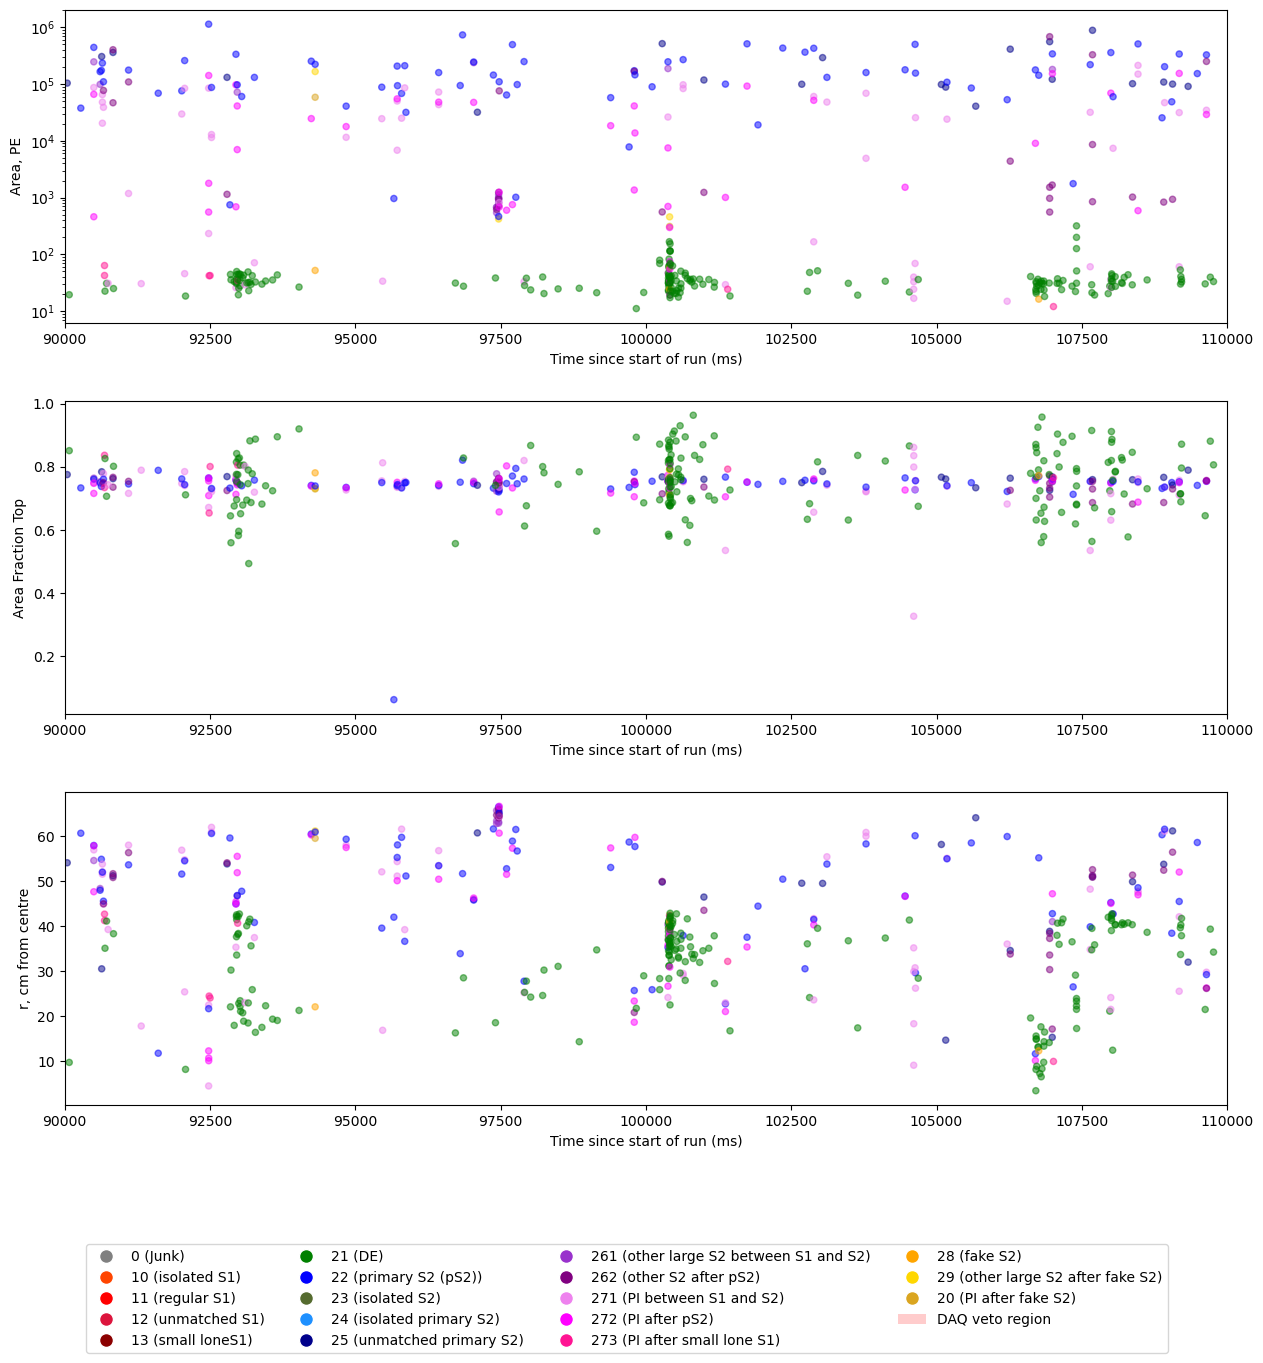

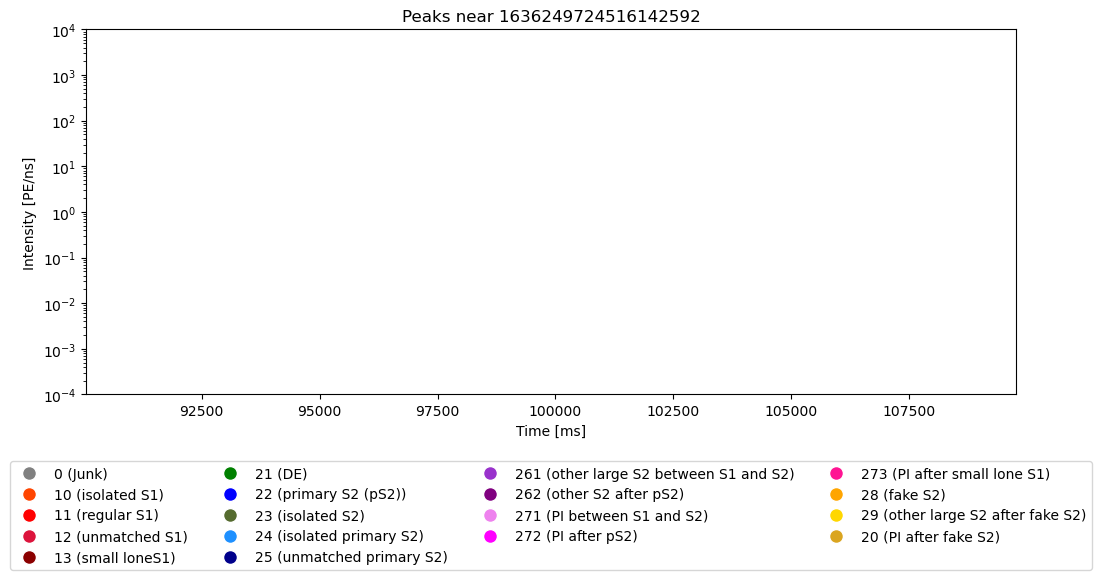

(<Figure size 1200x500 with 1 Axes>,
 <Axes: title={'center': 'Peaks near 1636249724516142592'}, xlabel='Time [ms]', ylabel='Intensity [PE/ns]'>)

In [79]:
pS2s_and_DEs = np.concatenate((pS2s, DEs_cut))
hf.data_investigation(pS2s_and_DEs, seconds_range = (90, 110))
hf.plot_peaks(run_id, pS2s_and_DEs, seconds_range = (90, 110), before = False)


----------------------------------------------------------------------------------------------------

This selection will incorporate 1223 pS2s
Corresponding to the seconds range of: 45.15 to 149.99
Running the cost function now
Minimisation Status: 
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.154e+04                  │              Nfcn = 355              │
│ EDM = 3.39e-05 (Goal: 0.0002)    │           time = 22.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼────────────────────────────

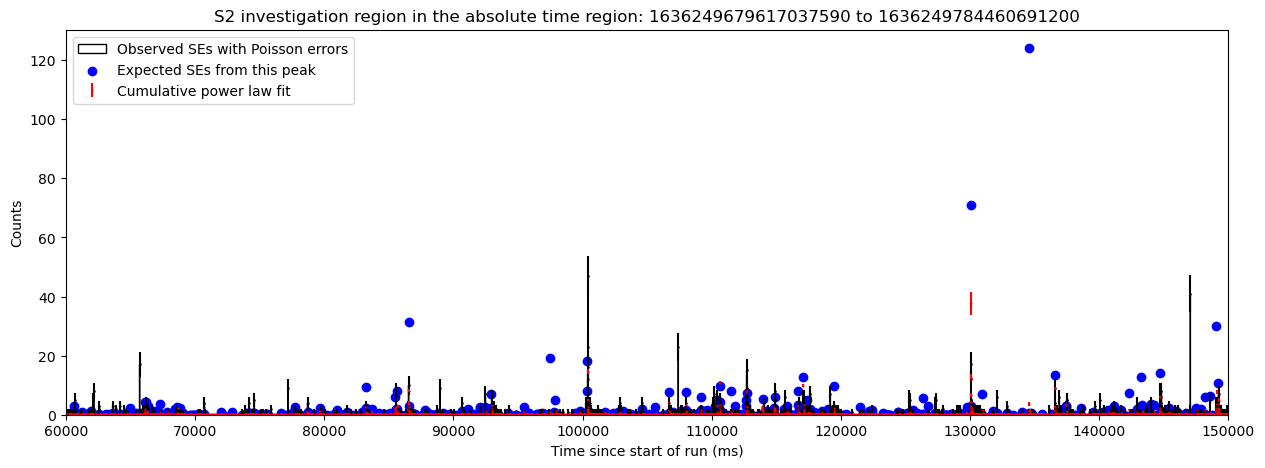

Total number of ses in range: 962
Predicted total number of ses in range: 1300.1426963373808


In [14]:
s2, se, va, co = mdn.time_fitting_buffer(run_id, pS2s, DEs_cut, seconds_range = (60, 150))
total, diff = mdn.cdf_plot(s2, se, va, co, seconds_range = (60, 150))

print(f"Total number of ses in range: {len(se)}")
print(f"Predicted total number of ses in range: {total}")

#TODO: accuracy of diff vs total. Is diff actually doing what we want?

#TODO: Model is overpredicting number of ses vs actual number, so perhaps radial model not working as intended just yet


----------------------------------------------------------------------------------------------------

This selection will incorporate 376 pS2s
Corresponding to the seconds range of: 0.30 to 29.96
Running the cost function now
Minimisation Status: 
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5308                       │              Nfcn = 459              │
│ EDM = 2.59e-05 (Goal: 0.0002)    │            time = 7.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼───────────────────────────────

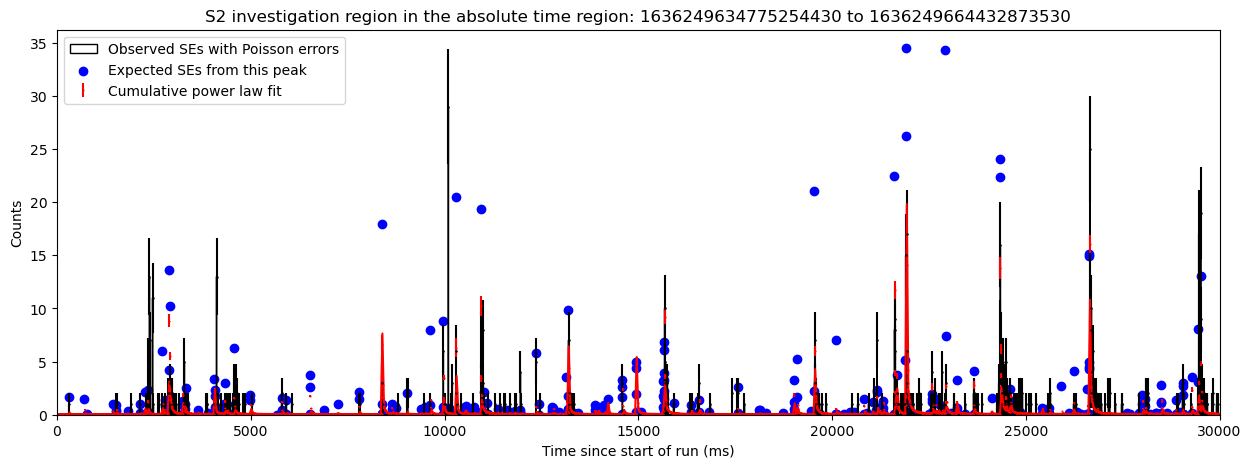

In [67]:
s24, se4, va4, co4 = mdn.time_fitting_buffer(run_id, pS2s, DEs_cut, seconds_range = (0, 30))
total4, diff4 = mdn.cdf_plot(s24, se4, va4, co4, seconds_range = (0, 30))

[272 271 262 271  22 272  22 272  22 272 272 262  20  20  20 272 272  20
 262 272  25  20 271 261  22 262 262 272 272 272 262  20  29  29  29  29
 262  22 262 262  20 272  29  20 262 262  29  20 272 272 261 261 272  20
  20 262  20 271  22  22  20 272  20 261 261 261 262  22 271  29  29 271
 271 272 272  20 262  20 272 262  22  29  20 272  20  25 272  20 262  20
  20  20  22 272  20 271  20 272  20 272  20  20 262 262 262 272 262 271
 261 271]
[   696.66095    388.0702     509.97357    494.49063    465.5989
    682.8644     997.6295     613.2617     668.21716    608.20593
    704.90076    526.1191     559.2302    1423.0016    1731.2491
   4155.812     3260.862      459.6236     714.71484   1212.478
   1710.8075     695.67816    804.3919     866.0574    1159.77
    864.1916    1018.58325   1365.8641     699.8856     873.7141
    655.0372     462.51184    586.68176    612.1801     775.18604
    523.4354     588.3778     706.5481     468.007      421.26373
   1299.6709    1915.0516     56

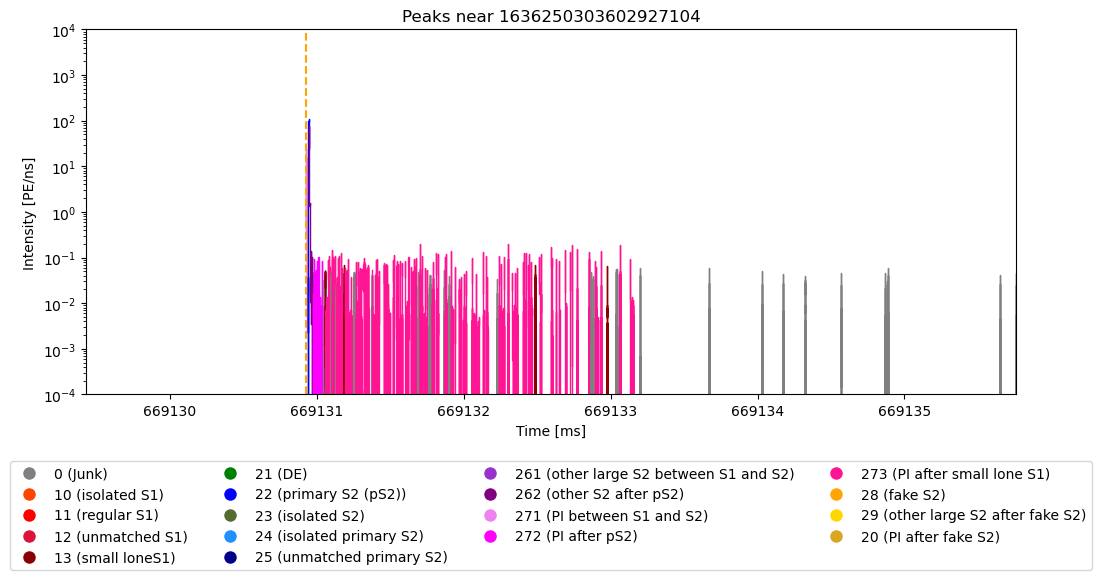

In [87]:
large_r_ps2s = pS2s[pS2s['r'] >= 66.5]

print(large_r_ps2s['subtype'])

print(large_r_ps2s['area'])

l = large_r_ps2s[large_r_ps2s['area'] == 26172.508]
m = large_r_ps2s[large_r_ps2s['area'] == 243570.64]
# n = large_r_ps2s[large_r_ps2s['area'] == 1211.1599]

print(l['subtype'], m['subtype'])
print(l['time since start'], m['time since start'])
# fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = hf.plot_peaks(run_id, peaks, t_reference = l['time'], before = False)
ax.axvline(l['time since start'], color = 'grey', linestyle = '--')

# print(diff)

# pred_electrons_l = mdn.compute_norms(va['s'], va['c'], va['d'], va['r0'], va['scaling'], l['area'], l['range_50p_area'] / 1e6, l['r'])
# print(f"Predicted electrons for large pS2: {pred_electrons_l}")
# pred_electrons_m = mdn.compute_norms(va['s'], va['c'], va['d'], va['r0'], va['scaling'], m['area'], m['range_50p_area'] / 1e6, m['r'])
# print(f"Predicted electrons for medium pS2: {pred_electrons_m}")

# g = large_r_ps2s[0]
# fig3, ax3 = hf.plot_peaks(run_id, peaks, t_reference = g['time'], before = False)

# h = large_r_ps2s[1]
# fig5, ax5 = hf.plot_peaks(run_id, peaks, t_reference = h['time'], before = False)

# i = large_r_ps2s[2]
# fig6, ax6 = hf.plot_peaks(run_id, peaks, t_reference = i['time'], before = False)

[211672.06 265169.4   69788.52]
[64.4504  64.46458 62.16017]
[25] [262] [262]
Peaks starting at time: 1636249644577790720
 This region spans 4910060 ns


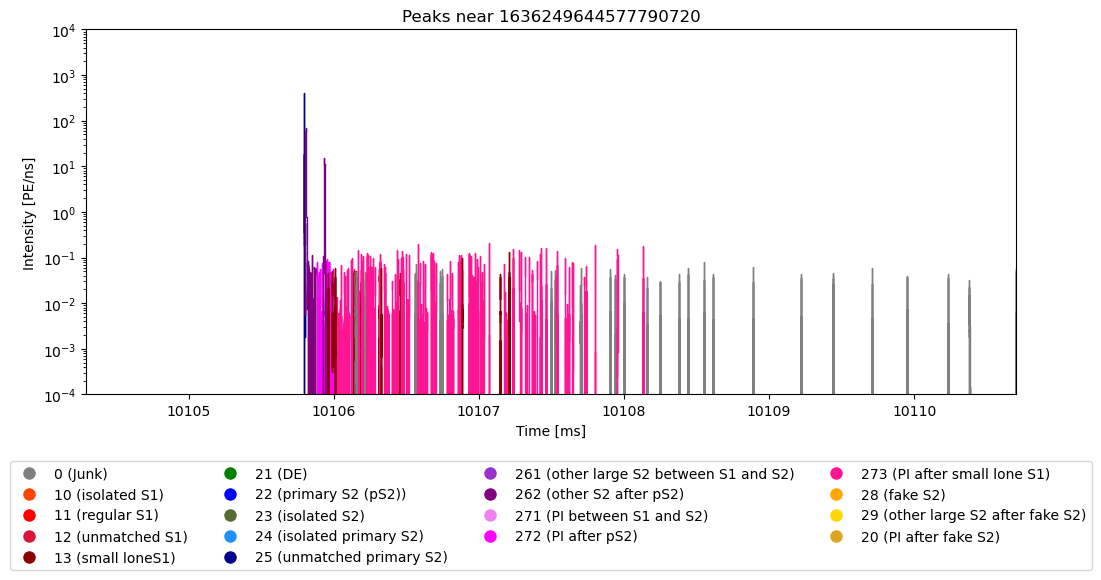

Predicted electrons for large burst a: [0.00077178]
Predicted electrons for large burst b: [0.01829657]


In [73]:
large_bursts = pS2s[(pS2s['time since start'] > (10 * 1e3)) & (pS2s['time since start'] < (10.2 * 1e3))]

print(large_bursts['area'])
print(large_bursts['r'])
a = large_bursts[large_bursts['area'] == 211672.06]
b = large_bursts[large_bursts['area'] == 265169.4]
c = large_bursts[large_bursts['area'] == 69788.52]

print(a['subtype'], b['subtype'], c['subtype'])

fig1, ax1 = hf.plot_peaks(run_id, peaks, t_reference = a['time'], before = False)

pred_electrons_a = mdn.compute_norms(va['s'], va['c'], va['d'], va['r0'], va['scaling'], a['area'], a['range_50p_area'] / 1e6, a['r'])
print(f"Predicted electrons for large burst a: {pred_electrons_a}")
pred_electrons_b = mdn.compute_norms(va['s'], va['c'], va['d'], va['r0'], va['scaling'], b['area'], b['range_50p_area'] / 1e6, b['r'])
print(f"Predicted electrons for large burst b: {pred_electrons_b}")


[89531.086]
[25.945456]
Peaks starting at time: 1636249734578582016
 This region spans 1988300 ns


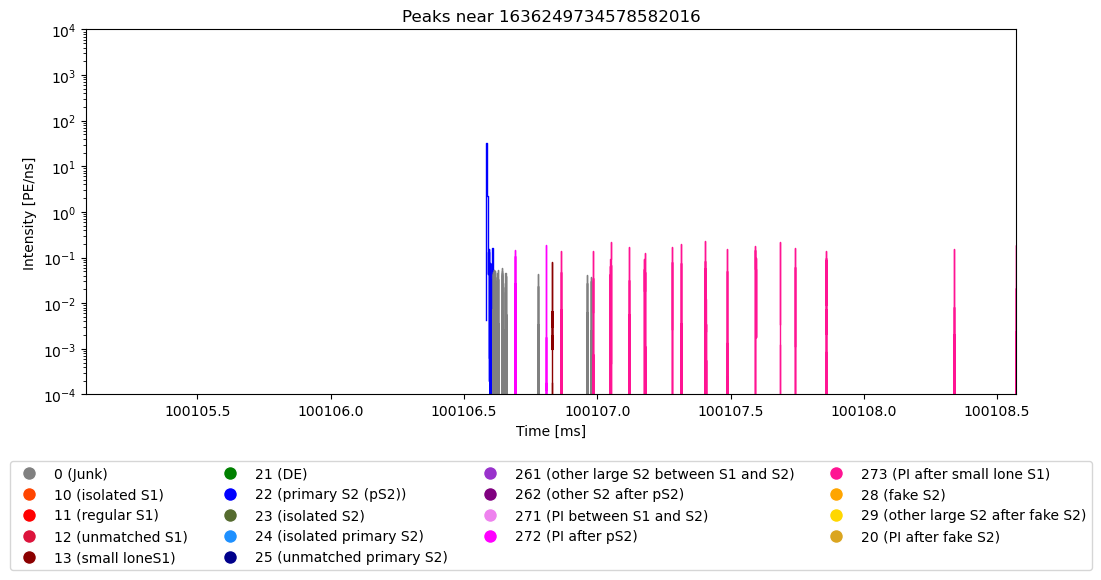

In [75]:
something = pS2s[(pS2s['time since start'] > (100 * 1e3)) & (pS2s['time since start'] < (100.2 * 1e3))]

print(something['area'])
print(something['r'])

fig2, ax2 = hf.plot_peaks(run_id, peaks, t_reference = something['time'], before = False)